In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Running from the root makes things easy

In [2]:
%cd ../..

/home/kamen/Workspace/Coursework/year4/mlp/mlp-03


In [3]:
from src.datautils.sandia import SandiaDataProvider

# Setup data provider

In [4]:
train_batch_size = 32
test_batch_size = 8

train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='datasets/sandia/',
                                  img_size=28)
val_data = SandiaDataProvider(which_set='valid',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)

# Define models

In [192]:
import src
import importlib
importlib.reload(src.autoencoders)

<module 'src.autoencoders' from '/home/kamen/Workspace/Coursework/year4/mlp/mlp-03/src/autoencoders.py'>

In [225]:
from src.autoencoders import Conv2DAutoencoder, PCAAutoencoder
from src.reasoning_agents import FFNReasoningAgent
from src.classifiers import PairwiseClassifier
from src.traizq import TRAIZQ

lr = 0.1
momentum = 0.5
use_cuda = torch.cuda.is_available()
latent_size = 100

# autoencoder = PCAAutoencoder(latent_size)
autoencoder = Conv2DAutoencoder(latent_size)

reasoning_agent = FFNReasoningAgent(latent_size)
classifier = PairwiseClassifier(latent_size)

model = TRAIZQ(autoencoder, reasoning_agent, classifier)
if use_cuda:
    model.cuda()

# Train only autoencoder

# If PCA

In [194]:
# train_data.inputs is still num_ex x im_width x im_height x num_im
X = train_data.inputs.transpose(3, 0, 1, 2).reshape(-1, 28 * 28)
model.autoencoder.train(X)

# If differentiable

In [226]:
optimizer = optim.SGD(model.autoencoder.parameters(), lr=lr, momentum=momentum)

In [231]:
log_interval = 50
losses = []
def train_autoencoder_only(epoch):
    model.autoencoder.train()
    # Get new gen object at every epoch
    train_loader = train_data.get_image_batch_iterator(train_batch_size)
    for batch_idx, (data, _) in enumerate(train_loader):
        # Set autoencoder target
        target = data
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        # Ignore latent representations
        output, _ = model.autoencoder(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if batch_idx % log_interval == 0:
            print('Train Epoch: {0} Loss: {1:.6f}'.format(epoch, loss.data[0]))

epochs = 4
for epoch in range(1, epochs + 1):
    train_autoencoder_only(epoch)

Train Epoch: 1 Loss: 0.715540
Train Epoch: 1 Loss: 0.841898
Train Epoch: 1 Loss: 0.679340
Train Epoch: 1 Loss: 0.705268
Train Epoch: 1 Loss: 0.784427
Train Epoch: 1 Loss: 0.877840
Train Epoch: 1 Loss: 0.683716
Train Epoch: 2 Loss: 1.000806
Train Epoch: 2 Loss: 0.806968
Train Epoch: 2 Loss: 0.635992
Train Epoch: 2 Loss: 1.220794
Train Epoch: 2 Loss: 0.677948
Train Epoch: 2 Loss: 0.902178
Train Epoch: 2 Loss: 0.524884
Train Epoch: 3 Loss: 0.802707
Train Epoch: 3 Loss: 0.533069
Train Epoch: 3 Loss: 0.646273
Train Epoch: 3 Loss: 0.527026
Train Epoch: 3 Loss: 0.761348
Train Epoch: 3 Loss: 0.782527
Train Epoch: 3 Loss: 0.725359
Train Epoch: 4 Loss: 0.504988
Train Epoch: 4 Loss: 0.802081
Train Epoch: 4 Loss: 0.496345
Train Epoch: 4 Loss: 0.663456
Train Epoch: 4 Loss: 0.648678
Train Epoch: 4 Loss: 0.580402
Train Epoch: 4 Loss: 0.643639


In [232]:
data, output = None, None
test_loader = test_data.get_image_batch_iterator(test_batch_size)
data, _ = next(test_loader)
# Set autoencoder target
target = data
if use_cuda:
    data, target = data.cuda(), target.cuda()
data, target = Variable(data), Variable(target)
optimizer.zero_grad()
# Ignore latent representations
output, _ = model.autoencoder(data)

In [233]:
data_np = data.squeeze().cpu().data.numpy()
output_np = output.squeeze().cpu().data.numpy()

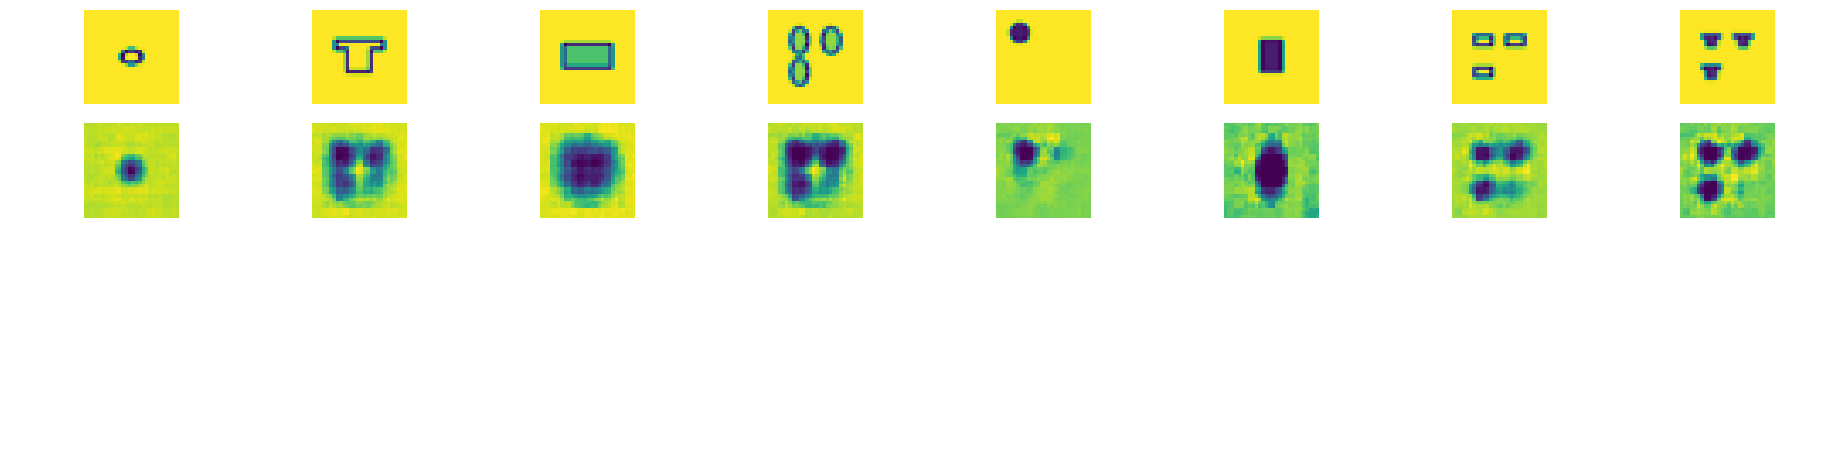

In [234]:
from src.utils import show_batch_of_images
show_batch_of_images(np.concatenate([data_np, output_np]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))

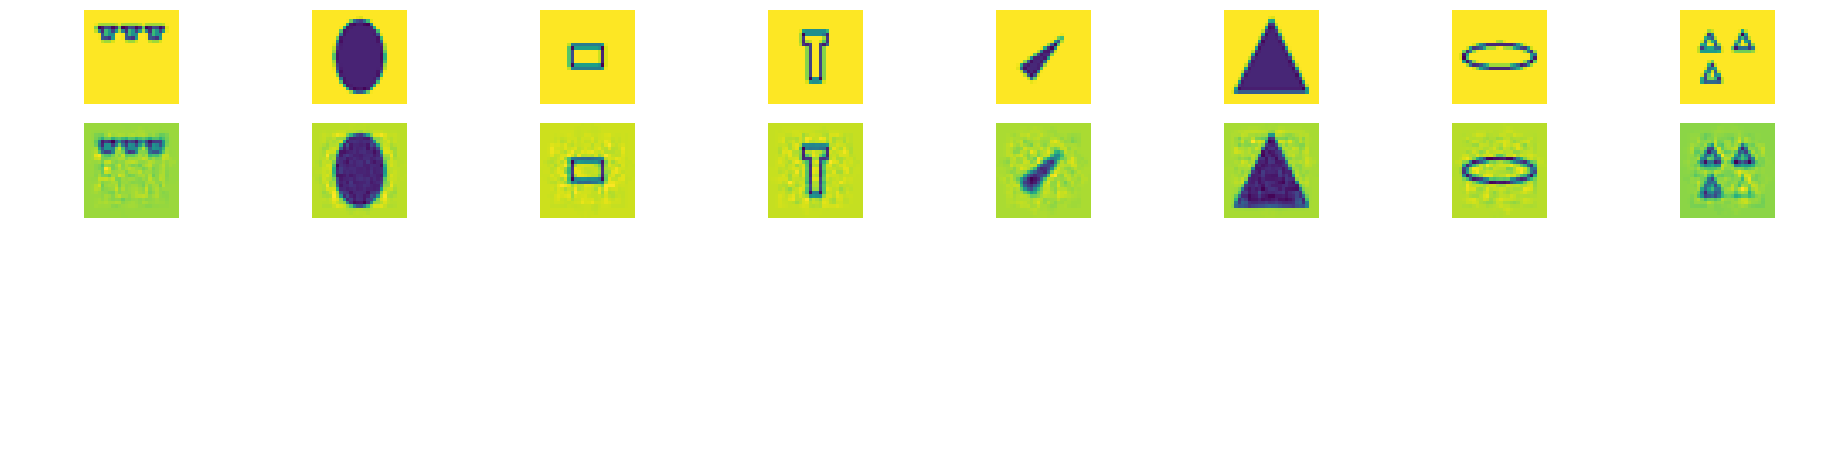

In [197]:
from src.utils import show_batch_of_images
show_batch_of_images(np.concatenate([data_np, output_np]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))

In [179]:
autoencoder.set_frozen(True)

### Train rest of architecture

In [198]:
optimizer = optim.SGD([x for x in model.parameters() if x.requires_grad], lr=lr, momentum=momentum)

In [199]:
import src
import importlib
importlib.reload(src.utils)
importlib.reload(src.train_test)

<module 'src.train_test' from '/home/kamen/Workspace/Coursework/year4/mlp/mlp-03/src/train_test.py'>

In [219]:
from src.train_test import train, test

epochs = 30
train(model, optimizer, train_data, val_data, use_cuda, train_batch_size, epochs)
test(model, optimizer, test_data, use_cuda, test_batch_size, ['3_layer'])

Train Epoch: 1 Loss: 5.774430
Train Epoch: 1 Loss: 5.249551
Train Epoch: 2 Loss: 3.452107
Train Epoch: 2 Loss: 7.525194
Train Epoch: 3 Loss: 7.823301
Train Epoch: 3 Loss: 9.880936
Train Epoch: 4 Loss: 6.224741
Train Epoch: 4 Loss: 3.354245
Train Epoch: 5 Loss: 7.764632
Train Epoch: 5 Loss: 3.137496
Train Epoch: 6 Loss: 3.603279
Train Epoch: 6 Loss: 5.119588
Train Epoch: 7 Loss: 5.247649
Train Epoch: 7 Loss: 10.804644
Train Epoch: 8 Loss: 5.034225
Train Epoch: 8 Loss: 3.851104
Train Epoch: 9 Loss: 7.322249
Train Epoch: 9 Loss: 15.831274
Train Epoch: 10 Loss: 4.278891
Train Epoch: 10 Loss: 6.317056
Train Epoch: 11 Loss: 8.299287
Train Epoch: 11 Loss: 2.812124
Train Epoch: 12 Loss: 6.583545
Train Epoch: 12 Loss: 11.986238
Train Epoch: 13 Loss: 6.941975
Train Epoch: 13 Loss: 5.428097
Train Epoch: 14 Loss: 11.196358
Train Epoch: 14 Loss: 3.058934
Train Epoch: 15 Loss: 5.110239
Train Epoch: 15 Loss: 10.207260
Train Epoch: 16 Loss: 4.078200
Train Epoch: 16 Loss: 3.208905
Train Epoch: 17 Loss:

In [220]:
from src.utils import make_vars
test_loader = test_data.get_batch_iterator(test_batch_size, transpose_inputs=True, separate_inputs=True)

(q_vectors, a_vectors), labels = next(test_loader)
q_vectors, a_vectors, labels = make_vars([q_vectors, a_vectors, labels], ['float', 'float', 'long'], use_cuda=use_cuda)
_, latent_prediction, decoded_q_vectors, _ = model(q_vectors, a_vectors)

In [222]:
targets = a_vectors

indices = torch.from_numpy(np.arange(8)).long()
if use_cuda:
    indices = indices.cuda()
targets = targets[indices, labels.data].squeeze()

In [209]:
# When differentiable AE
decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size, 1, 1)).squeeze()

ValueError: shapes (8,100,1,1) and (100,784) not aligned: 1 (dim 3) != 100 (dim 0)

In [223]:
# When PCA
decoded_prediction = model.autoencoder.decoder(latent_prediction.view(-1, latent_size)).squeeze().view(test_batch_size, 28, 28)

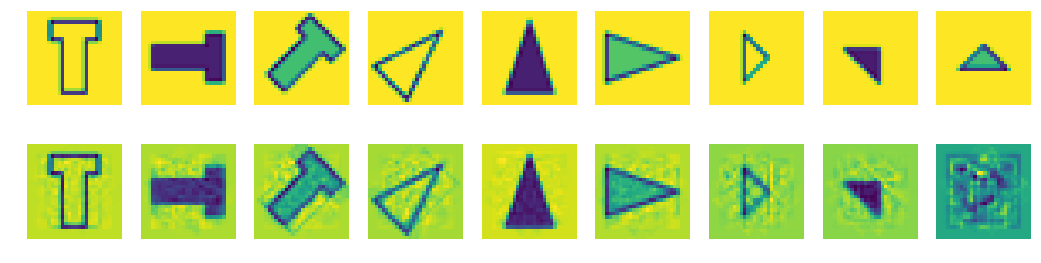

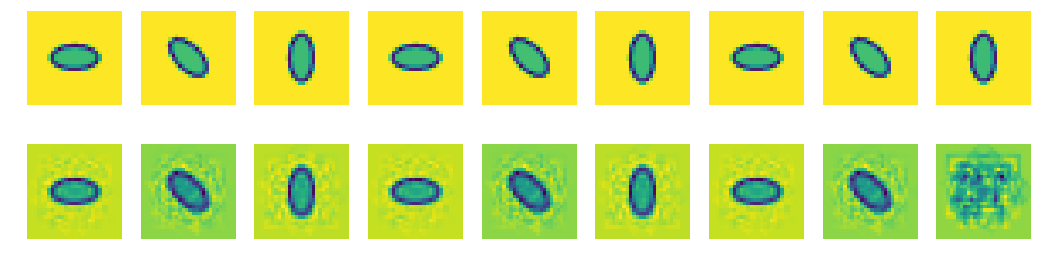

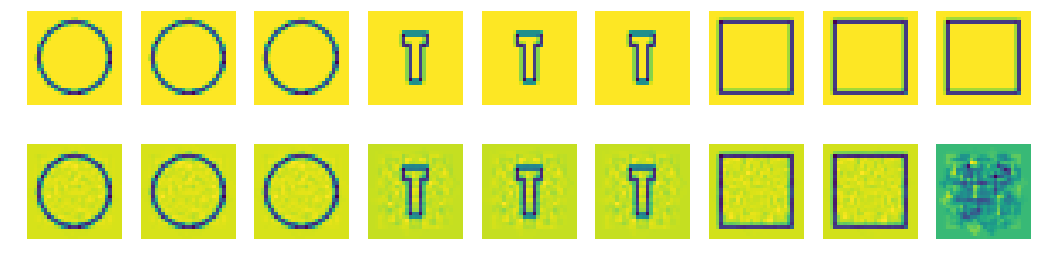

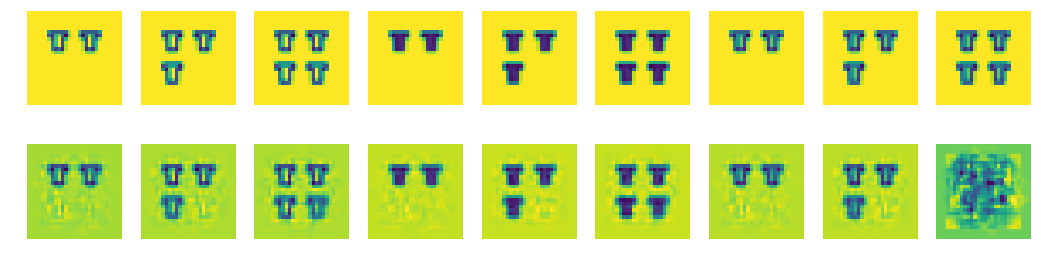

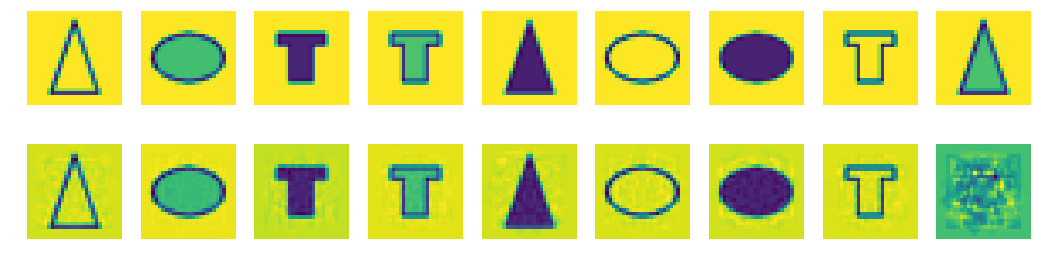

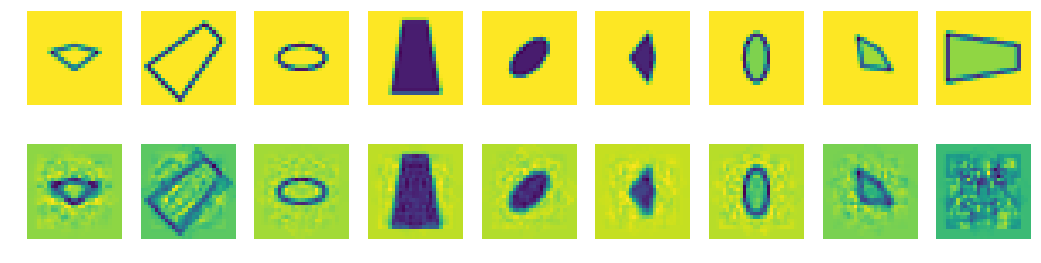

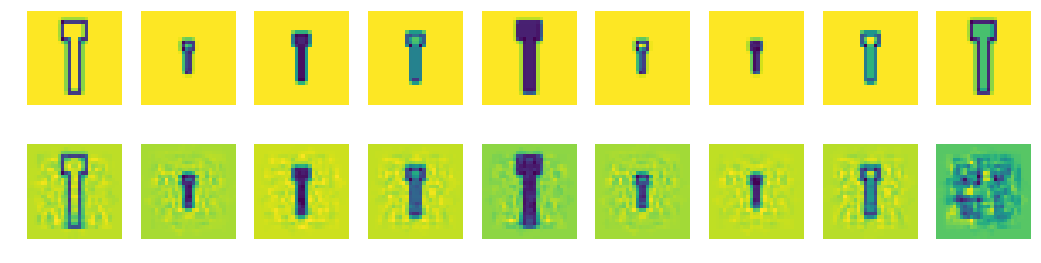

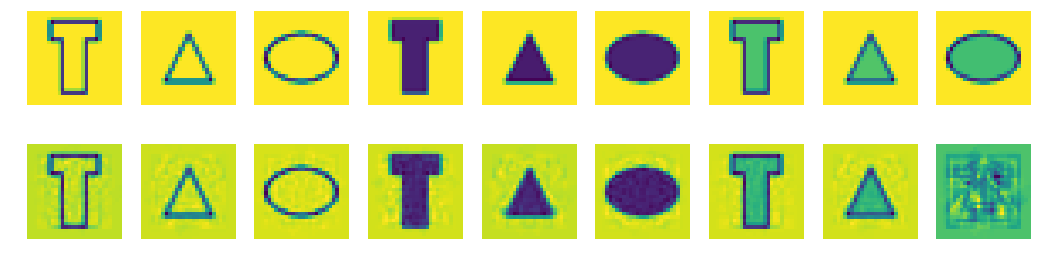

In [224]:
from src.utils import show_matrix
show_matrix(q_vectors, targets, decoded_q_vectors, decoded_prediction)